In [1]:
import numpy as np
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping, LearningRateScheduler

import time
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Φόρτωση CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Διαμόρφωση των δεδομένων (reshape για PCA)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# PCA: Διατήρηση πάνω από 90% της πληροφορίας
pca = PCA(0.95)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

2025-01-10 15:37:41.885657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736516261.958794    4599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736516261.980251    4599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 15:37:42.124745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [2]:
#ALLAGH K-MEANS METRHSEIS

In [2]:
# RBF Neural Network
class RBFNN(tf.keras.Model):
    def __init__(self, n_centers, n_classes, input_dim, training_data):
        super(RBFNN, self).__init__()
        self.n_centers = n_centers

        # Υπολογισμός των RBF κέντρων με K-Means
        self.centers = self.init_centers_with_kmeans(training_data)
        
        # Initialize betas based on distances between centers
        self.betas = self.init_betas(self.centers)
        
        # Dense layer for classification
        self.dense = tf.keras.layers.Dense(
            n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.RandomNormal()
        )

    def init_centers_with_kmeans(self, data):
        """Υπολογισμός κέντρων με K-Means clustering."""
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(data)
        return tf.Variable(kmeans.cluster_centers_, trainable=True, dtype=tf.float32, name="centers")

    def init_betas(self, centers):
        # Compute distances between all centers
        distances = tf.reduce_mean(
            tf.norm(
                tf.expand_dims(centers, axis=0) - tf.expand_dims(centers, axis=1), axis=2
            ),
            axis=1
        )
        # Return betas based on distances
        return tf.Variable(1 / (2 * distances ** 2), trainable=True, name="betas")

    def rbf_layer(self, inputs):
        # Υπολογισμός των RBF συναρτήσεων
        dists = tf.reduce_sum((tf.expand_dims(inputs, 1) - self.centers) ** 2, axis=2)
        rbf_outputs = tf.exp(-self.betas * dists)
        return rbf_outputs

    def call(self, inputs):
        rbf_outputs = self.rbf_layer(inputs)
        outputs = self.dense(rbf_outputs)
        return outputs

In [9]:
# Εκπαίδευση και αξιολόγηση με cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies, test_accuracies, train_times = [], [], []

for train_index, val_index in kf.split(x_train_pca):
    x_train_cv, x_val_cv = x_train_pca[train_index], x_train_pca[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model_B = RBFNN(
        n_centers=1000,
        n_classes=10,
        input_dim=x_train_pca.shape[1],
        training_data=x_train_pca
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model_B.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Εκκίνηση του χρόνου εκπαίδευσης
    start_time = time.time()

    # Εκπαίδευση
    history = model_B.fit(
        x_train_cv, y_train_cv, 
        validation_data=(x_val_cv, y_val_cv),
        epochs=80, 
        batch_size=64, 
        verbose=1
    )

    # Καταγραφή χρόνου
    end_time = time.time()
    train_times.append(end_time - start_time)

    # Ακρίβεια στο σύνολο ελέγχου
    train_acc = max(history.history['accuracy'])
    val_acc   = max(history.history['val_accuracy'])

    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)

2025-01-10 01:43:12.074209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.
2025-01-10 01:43:12.265118: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.


Epoch 1/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.1458 - loss: 2.2833 - val_accuracy: 0.2173 - val_loss: 2.1573
Epoch 2/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.2321 - loss: 2.1416 - val_accuracy: 0.2454 - val_loss: 2.1081
Epoch 3/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2461 - loss: 2.1006 - val_accuracy: 0.2395 - val_loss: 2.0841
Epoch 4/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2591 - loss: 2.0708 - val_accuracy: 0.2591 - val_loss: 2.0614
Epoch 5/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2662 - loss: 2.0508 - val_accuracy: 0.2713 - val_loss: 2.0490
Epoch 6/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.2696 - loss: 2.0442 - val_accuracy: 0.2619 - val_loss: 2.0408
Epoch 7/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.2743 - loss: 2.0287 - val_accuracy: 0.2785 - val_loss: 2.0229
Epoch 8/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.2793 - loss: 2.0193 - 

2025-01-10 02:09:06.079158: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.


Epoch 1/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1616 - loss: 2.2623 - val_accuracy: 0.1973 - val_loss: 2.1538
Epoch 2/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2234 - loss: 2.1429 - val_accuracy: 0.2313 - val_loss: 2.1074
Epoch 3/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2477 - loss: 2.0999 - val_accuracy: 0.2539 - val_loss: 2.0782
Epoch 4/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2562 - loss: 2.0733 - val_accuracy: 0.2449 - val_loss: 2.0658
Epoch 5/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2655 - loss: 2.0556 - val_accuracy: 0.2619 - val_loss: 2.0438
Epoch 6/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.2713 - loss: 2.0411 - val_accuracy: 0.2680 - val_loss: 2.0321
Epoch 7/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.2732 - loss: 2.0293 - val_accuracy: 0.2714 - val_loss: 2.0194
Epoch 8/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2761 - loss: 2.0231 - 

Cross-validation Training Accuracies:  [0.3405250012874603, 0.3419249951839447, 0.3406749963760376, 0.3383750021457672, 0.3402499854564667]
Cross-validation Validation Accuracies:  [0.33970001339912415, 0.3384999930858612, 0.33799999952316284, 0.34689998626708984, 0.3472999930381775]
Average Training Time per Fold: 1557.32 seconds
Test Accuracy: 34.69%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


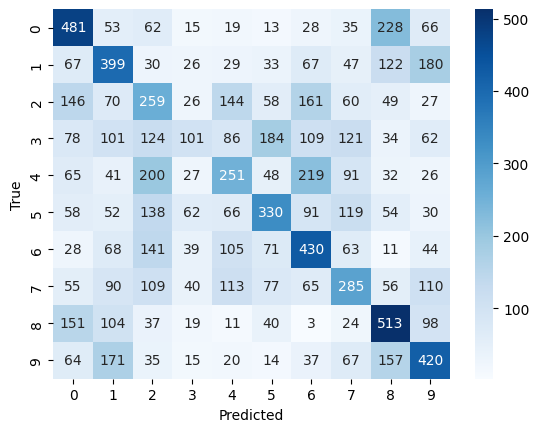

In [10]:
# Τελική αξιολόγηση στο test set
test_loss, test_accuracy = model_B.evaluate(x_test_pca, y_test, verbose=0)
# Αποτελέσματα
print("Cross-validation Training Accuracies: ", train_accuracies)
print("Cross-validation Validation Accuracies: ", test_accuracies)
print("Average Training Time per Fold: {:.2f} seconds".format(np.mean(train_times)))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

y_pred = model_B.predict(x_test_pca)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# 2000 kentra

In [ ]:
# Εκπαίδευση και αξιολόγηση με cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies, test_accuracies, train_times = [], [], []

for train_index, val_index in kf.split(x_train_pca):
    x_train_cv, x_val_cv = x_train_pca[train_index], x_train_pca[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model_B = RBFNN(
        n_centers=2000,
        n_classes=10,
        input_dim=x_train_pca.shape[1],
        training_data=x_train_pca
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model_B.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Εκκίνηση του χρόνου εκπαίδευσης
    start_time = time.time()

    # Εκπαίδευση
    history = model_B.fit(
        x_train_cv, y_train_cv, 
        validation_data=(x_val_cv, y_val_cv),
        epochs=80, 
        batch_size=64, 
        verbose=1
    )

    # Καταγραφή χρόνου
    end_time = time.time()
    train_times.append(end_time - start_time)

    # Ακρίβεια στο σύνολο ελέγχου
    train_acc = max(history.history['accuracy'])
    val_acc   = max(history.history['val_accuracy'])

    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)

In [ ]:
# Τελική αξιολόγηση στο test set
test_loss, test_accuracy = model_B.evaluate(x_test_pca, y_test, verbose=0)
# Αποτελέσματα
print("Cross-validation Training Accuracies: ", train_accuracies)
print("Cross-validation Validation Accuracies: ", test_accuracies)
print("Average Training Time per Fold: {:.2f} seconds".format(np.mean(train_times)))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

y_pred = model_B.predict(x_test_pca)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# TELIKO OLWN

In [3]:
# RBF Neural Network
class RBFNN(tf.keras.Model):
    def __init__(self, n_centers, n_classes, input_dim, training_data):
        super(RBFNN, self).__init__()
        self.n_centers = n_centers

        # Υπολογισμός των RBF κέντρων με K-Means
        self.centers = self.init_centers_with_kmeans(training_data)
        # Initialize betas based on distances between centers
        self.betas = self.init_betas(self.centers)
        
        # Dense layer for classification
        self.dense1 = tf.keras.layers.Dense(
            256, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.output_layer = tf.keras.layers.Dense(
            n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal()
        )

    def init_centers_with_kmeans(self, data):
        """Υπολογισμός κέντρων με K-Means clustering."""
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(data)
        return tf.Variable(kmeans.cluster_centers_, trainable=True, dtype=tf.float32, name="centers")

    def init_betas(self, centers):
        # Compute distances between all centers
        distances = tf.reduce_mean(
            tf.norm(
                tf.expand_dims(centers, axis=0) - tf.expand_dims(centers, axis=1), axis=2
            ),
            axis=1
        )
        # Return betas based on distances
        return tf.Variable(1 / (2 * distances ** 2), trainable=True, name="betas")

    def rbf_layer(self, inputs):
        # Υπολογισμός των RBF συναρτήσεων
        dists = tf.reduce_sum((tf.expand_dims(inputs, 1) - self.centers) ** 2, axis=2)
        rbf_outputs = tf.exp(-self.betas * dists)
        return rbf_outputs

    def call(self, inputs):
        rbf_outputs = self.rbf_layer(inputs)
        x = self.dense1(rbf_outputs)
        outputs = self.output_layer(x)
        return outputs

In [4]:
# Εκπαίδευση και αξιολόγηση με cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies, test_accuracies, train_times = [], [], []

for train_index, val_index in kf.split(x_train_pca):
    x_train_cv, x_val_cv = x_train_pca[train_index], x_train_pca[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model_B = RBFNN(
        n_centers=1000,
        n_classes=10,
        input_dim=x_train_pca.shape[1],
        training_data=x_train_pca
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model_B.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Εκκίνηση του χρόνου εκπαίδευσης
    start_time = time.time()

    # Εκπαίδευση
    history = model_B.fit(
        x_train_cv, y_train_cv, 
        validation_data=(x_val_cv, y_val_cv),
        epochs=150, 
        batch_size=64, 
        verbose=1
    )
    # Αποθήκευση του μοντέλου
    model_B.save("rbfnn_model_FINAL.keras")
    
    # Καταγραφή χρόνου
    end_time = time.time()
    train_times.append(end_time - start_time)

    # Ακρίβεια στο σύνολο ελέγχου
    train_acc = max(history.history['accuracy'])
    val_acc   = max(history.history['val_accuracy'])

    train_accuracies.append(train_acc)
    test_accuracies .append(val_acc)

2025-01-10 15:39:16.250059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-01-10 15:39:16.278324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.
2025-01-10 15:39:16.525316: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.


Epoch 1/150


/home/ntoylker/myenv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'rbfnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.1847 - loss: 2.2134 - val_accuracy: 0.2556 - val_loss: 2.0717
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2589 - loss: 2.0585 - val_accuracy: 0.2625 - val_loss: 2.0180
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.2772 - loss: 2.0016 - val_accuracy: 0.2860 - val_loss: 1.9796
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.2897 - loss: 1.9704 - val_accuracy: 0.2889 - val_loss: 1.9494
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.2941 - loss: 1.9463 - val_accuracy: 0.2968 - val_loss: 1.9310
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.3059 - loss: 1.9216 - val_accuracy: 0.3017 - val_loss: 1.9039
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3118 - loss: 1.9054 - val_accuracy: 0.3105 - val_loss: 1.9109
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.3149 - loss: 1.8978 - val_

2025-01-10 16:36:37.269933: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.
2025-01-10 16:36:37.465936: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.


Epoch 1/150


/home/ntoylker/myenv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'rbfnn_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2005 - loss: 2.1829 - val_accuracy: 0.2513 - val_loss: 2.0667
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.2632 - loss: 2.0515 - val_accuracy: 0.2720 - val_loss: 2.0187
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.2737 - loss: 2.0059 - val_accuracy: 0.2744 - val_loss: 1.9827
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2857 - loss: 1.9738 - val_accuracy: 0.2886 - val_loss: 1.9523
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2995 - loss: 1.9390 - val_accuracy: 0.3042 - val_loss: 1.9230
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3041 - loss: 1.9191 - val_accuracy: 0.2976 - val_loss: 1.9245
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.3138 - loss: 1.9051 - val_accuracy: 0.2965 - val_loss: 1.9166
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3191 - loss: 1.8843 - val_

2025-01-10 18:03:18.934640: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868000000 exceeds 10% of free system memory.


Epoch 1/150


/home/ntoylker/myenv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'rbfnn_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.1811 - loss: 2.1984 - val_accuracy: 0.2595 - val_loss: 2.0553
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2636 - loss: 2.0456 - val_accuracy: 0.2774 - val_loss: 2.0027
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.2804 - loss: 1.9907 - val_accuracy: 0.2848 - val_loss: 1.9675
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2877 - loss: 1.9647 - val_accuracy: 0.2884 - val_loss: 1.9520
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.3039 - loss: 1.9316 - val_accuracy: 0.3049 - val_loss: 1.9202
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.3071 - loss: 1.9149 - val_accuracy: 0.3126 - val_loss: 1.8899
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.3142 - loss: 1.8938 - val_accuracy: 0.3143 - val_loss: 1.8809
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.3184 - loss: 1.8817 - val_

/home/ntoylker/myenv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'rbfnn_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1978 - loss: 2.1978 - val_accuracy: 0.2544 - val_loss: 2.0779
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2619 - loss: 2.0447 - val_accuracy: 0.2806 - val_loss: 2.0104
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.2764 - loss: 1.9984 - val_accuracy: 0.2811 - val_loss: 1.9731
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2869 - loss: 1.9644 - val_accuracy: 0.2997 - val_loss: 1.9554
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2955 - loss: 1.9393 - val_accuracy: 0.3112 - val_loss: 1.9234
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3031 - loss: 1.9207 - val_accuracy: 0.3153 - val_loss: 1.9146
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3075 - loss: 1.9057 - val_accuracy: 0.3241 - val_loss: 1.8890
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3172 - loss: 1.8865 - val_

/home/ntoylker/myenv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'rbfnn_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.1808 - loss: 2.2100 - val_accuracy: 0.2799 - val_loss: 2.0536
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2593 - loss: 2.0548 - val_accuracy: 0.2843 - val_loss: 2.0114
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2745 - loss: 2.0036 - val_accuracy: 0.2925 - val_loss: 1.9612
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2892 - loss: 1.9696 - val_accuracy: 0.3151 - val_loss: 1.9277
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3015 - loss: 1.9425 - val_accuracy: 0.3022 - val_loss: 1.9297
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3051 - loss: 1.9173 - val_accuracy: 0.3192 - val_loss: 1.8969
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3100 - loss: 1.9066 - val_accuracy: 0.3251 - val_loss: 1.8744
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3181 - loss: 1.8887 - val_

Cross-validation Training Accuracies:  [0.4194999933242798, 0.42147499322891235, 0.421750009059906, 0.4183749854564667, 0.42225000262260437]
Cross-validation Validation Accuracies:  [0.42329999804496765, 0.41600000858306885, 0.41690000891685486, 0.42410001158714294, 0.4214000105857849]
Average Training Time per Fold: 3725.11 seconds
Test Accuracy: 42.37%
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


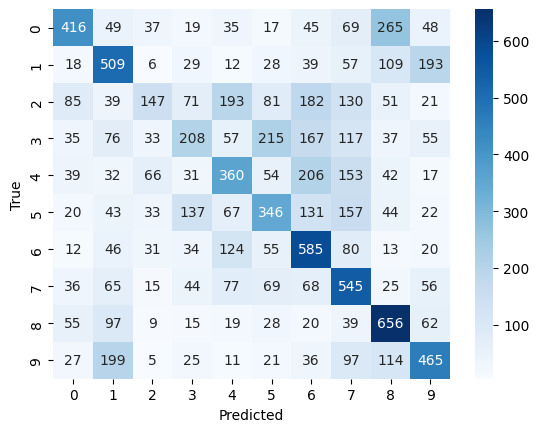

In [5]:
# Τελική αξιολόγηση στο test set
test_loss, test_accuracy = model_B.evaluate(x_test_pca, y_test, verbose=0)
# Αποτελέσματα
print("Cross-validation Training Accuracies: ", train_accuracies)
print("Cross-validation Validation Accuracies: ", test_accuracies)
print("Average Training Time per Fold: {:.2f} seconds".format(np.mean(train_times)))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

y_pred = model_B.predict(x_test_pca)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


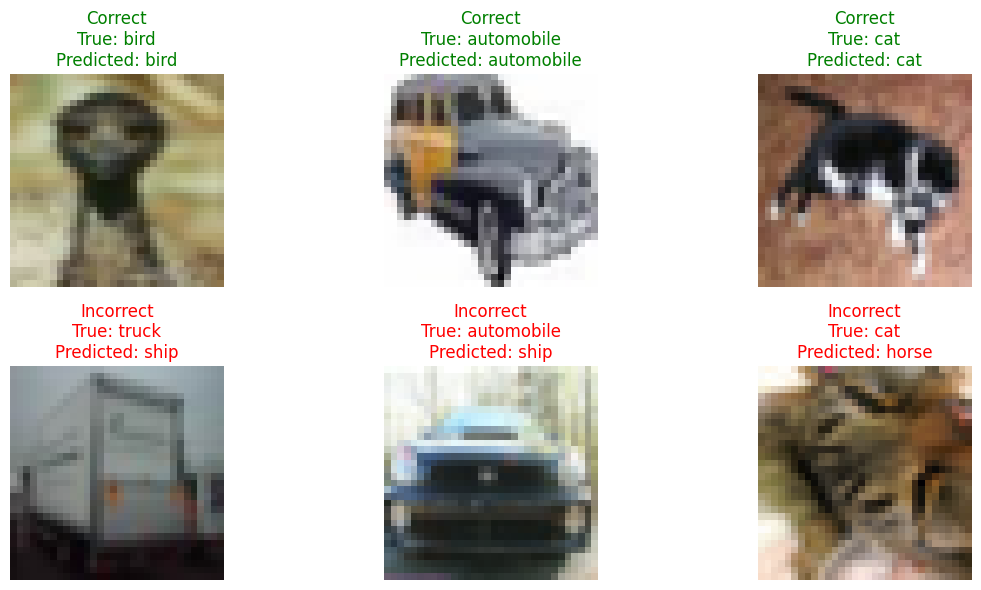

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Αντιστοίχιση των labels του CIFAR-10
class_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]

# Φόρτωση του αποθηκευμένου μοντέλου
#model_B_loaded = tf.keras.models.load_model("rbfnn_model_FINAL.keras", compile=False)

# Πρόβλεψη στο σύνολο ελέγχου
predictions = model_B.predict(x_test_pca)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Εύρεση σωστών και λανθασμένων ταξινομήσεων
correct_indices = np.where(predicted_labels == true_labels)[0]
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Επιλογή 3 σωστών και 3 λανθασμένων ταξινομήσεων
correct_samples   = np.random.choice(correct_indices, 3, replace=False)
incorrect_samples = np.random.choice(incorrect_indices, 3, replace=False)

# Συνδυασμός των δειγμάτων για εμφάνιση
samples_to_plot = np.concatenate([correct_samples, incorrect_samples])

# Εμφάνιση των αποτελεσμάτων
plt.figure(figsize=(12, 6))
for i, idx in enumerate(samples_to_plot):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_test[idx])
    true_label = class_names[true_labels[idx]]
    pred_label = class_names[predicted_labels[idx]]
    if i < 3:
        plt.title(f"Correct\nTrue: {true_label}\nPredicted: {pred_label}", color='green')
    else:
        plt.title(f"Incorrect\nTrue: {true_label}\nPredicted: {pred_label}", color='red')
    plt.axis('off')


plt.tight_layout()
plt.show()